# <font size="5">Libraries Imported:</font>
* <font size="4">**pandas:** Library for data manipulation and analysis using DataFrames.</font>
* <font size="4">**sklearn:** Machine learning library for data preprocessing, model selection, and evaluation.</font>
* <font size="4">**matplotlib.pyplot:** Create static and interactive visualizations.</font>
* <font size="4">**seaborn:** Statistical data visualization library based on matplotlib.</font>
* <font size="4">**lightgbm:** Gradient boosting framework using tree-based learning algorithms, designed for efficiency and scalability.</font>
* <font size="4">**xgboost:** Optimized gradient boosting library.</font>
* <font size="4">**sklearn.ensemble.ExtraTreesRegressor:** Fit multiple randomized trees, average results.</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-car-price-prediction-dataset/used_cars.csv


# Functions to Extract Features

In [2]:
#extracting features using regex to identify patterns and extract accordingly
def extract_engine_features(engine_str):  #extracting the engine features
    hp = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    litres = re.search(r'(\d+(\.\d+)?) ?(L|Liter?)', engine_str)
    cylinders = re.search(r'(\d+) Cylinder', engine_str)
    engine_config = re.search(r'(V\d+|Straight \d+)', engine_str)
    return {
        'horsepower': float(hp.group(1)) if hp else engine_str,
        'engine_capacity': float(litres.group(1)) if litres else None,
        'num_cylinders': int(cylinders.group(1)) if cylinders else None,
        'engine_configuration': engine_config.group(1) if engine_config else "No info"
    }

def extract_transmission_features(trans_str):  #extracting transmission features
    gears = re.search(r'(\d+)-Speed', trans_str)
    transmission_type = 'Automatic' if 'A/T' in trans_str or 'Automatic' in trans_str else ('Manual' if 'M/T' in trans_str or 'Manual' in trans_str else "Automatic")
    
    return {
        'num_gears': int(gears.group(1)) if gears else trans_str,
        'transmission_type': transmission_type
    }

def extract_features_from_engine_transmission(df):  #extracting engine transmission features
    engine_features = df['engine'].apply(extract_engine_features).apply(pd.Series)
    transmission_features = df['transmission'].apply(extract_transmission_features).apply(pd.Series)

    df = pd.concat([df, engine_features, transmission_features], axis=1)
    return df
    
def impute_hp(df):   #using knn imputer for the column horsepower
    copy = df.copy()

    transform = ["horsepower"]

    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()
    le = LabelEncoder()

    for col in copy.columns:
        if copy[col].dtype == "object":
            copy[col] = le.fit_transform(copy[col].astype(str))

    copy_scaled = scaler.fit_transform(copy.drop(columns=transform))
    copy_scaled_df = pd.DataFrame(copy_scaled, columns=copy.drop(columns=transform).columns)

    copy_scaled_df.reset_index(drop=True, inplace=True)
    train_transform = df[transform].reset_index(drop=True)

    copy = pd.concat([copy_scaled_df, train_transform], axis=1)

    copy_transform = imputer.fit_transform(copy)
    copy = pd.DataFrame(copy_transform, columns=copy.columns)

    df[transform] = copy[transform]
    return df

def ohe_everything(df):  #one hot encoding
    df = pd.concat([df, pd.get_dummies(df['fuel_type'], prefix='fuel')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['num_cylinders'], prefix='num_cylinders')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['engine_configuration'], prefix='engine_configuration')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['num_gears_n'], prefix='num_gears_n')], axis=1)
    return df

def bin_everything(df):
    df['car_age_bin'] = pd.cut(df['car_age'], bins=[-1, 5, 10, 20, np.inf], labels=['New', 'Moderate', 'Old', 'Very Old'])

    df['milage_bin'] = pd.cut(df['milage'], 
                              bins=[-1, 32268, 66107, 102000, np.inf], 
                              labels=['Low', 'Medium', 'High', 'Very High'])
    df['engine_capacity_bin'] = pd.cut(df['engine_capacity'], 
                                       bins=[-1, 3.0, 3.5, 4.6, np.inf], 
                                       labels=['Very Small', 'Small', 'Medium', 'Large'])

    df['num_gears_bin'] = pd.cut(df['num_gears_n'], 
                                 bins=[-1, 6, 8, np.inf], 
                                 labels=['Few', 'Moderate', 'Many'])
    return df

def ohe_binned(df):
    bin_columns = ['milage_bin', 'car_age_bin', 'engine_capacity_bin', 'num_gears_bin']
    df = pd.get_dummies(df, columns=bin_columns)
    return df

def compare_dataframes(train, test):
    train_columns = set(train.columns)
    test_columns = set(test.columns)
    all_missing_columns = train_columns.symmetric_difference(test_columns)

    if all_missing_columns:
        print("\nMissing columns (combined):", all_missing_columns)
    else:
        print("\nBoth DataFrames have all columns present in each other.")
    return df
    
def encode_obj(df):
    le = LabelEncoder()

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)
            df[col] = le.fit_transform(df[col])
    return df

def drop_cols_knowledge(df):
    columns_to_drop = ["engine", "transmission", "engine_configuration", "num_gears"]

    df = df.drop(columns=columns_to_drop)
    return df

In [3]:
data = pd.read_csv("/kaggle/input/used-car-price-prediction-dataset/used_cars.csv")
data['milage'] = data['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(int)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   int64 
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 376.0+ KB


# Data Pre-Proccesing

In [5]:
def preprocess(df):
    df = df.drop(columns=[ 'clean_title'])
    df = df.dropna(axis=0, how='any')
    df = extract_features_from_engine_transmission(df)
    df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
    df['num_gears_n'] = pd.to_numeric(df['num_gears'], errors='coerce')
    df = impute_hp(df)
    df = ohe_everything(df)
    df['car_age'] = 2024 - df['model_year']
    df = df.drop(columns=['model_year'])
    df = bin_everything(df)
    df = ohe_binned(df)
    df = encode_obj(df)
    df = drop_cols_knowledge(df)
    return df

data = preprocess(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3730 entries, 0 to 4008
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   brand                            3730 non-null   int64  
 1   model                            3730 non-null   int64  
 2   milage                           3730 non-null   int64  
 3   fuel_type                        3730 non-null   int64  
 4   ext_col                          3730 non-null   int64  
 5   int_col                          3730 non-null   int64  
 6   accident                         3730 non-null   int64  
 7   price                            3730 non-null   int64  
 8   horsepower                       3473 non-null   float64
 9   engine_capacity                  3677 non-null   float64
 10  num_cylinders                    2984 non-null   float64
 11  transmission_type                3730 non-null   int64  
 12  num_gears_n              

In [7]:
columns_to_impute = [
    'horsepower', "num_cylinders", "engine_capacity"
]

for column in columns_to_impute:
    mode_value = data[column].mode()[0]   #replacing Nan values with mode 
    data[column].fillna(mode_value, inplace=True)
data = data.drop(columns=['num_gears_n'])

In [8]:
data.isna().sum()

brand                              0
model                              0
milage                             0
fuel_type                          0
ext_col                            0
int_col                            0
accident                           0
price                              0
horsepower                         0
engine_capacity                    0
num_cylinders                      0
transmission_type                  0
fuel_Diesel                        0
fuel_E85 Flex Fuel                 0
fuel_Gasoline                      0
fuel_Hybrid                        0
fuel_Plug-In Hybrid                0
fuel_not supported                 0
fuel_–                             0
num_cylinders_3.0                  0
num_cylinders_4.0                  0
num_cylinders_5.0                  0
num_cylinders_6.0                  0
num_cylinders_8.0                  0
num_cylinders_10.0                 0
num_cylinders_12.0                 0
engine_configuration_No info       0
e

price                              1.000000
milage_bin_Low                     0.322489
milage                             0.301636
engine_configuration_V12           0.264531
car_age_bin_New                    0.198477
milage_bin_Very High               0.195091
car_age                            0.193587
engine_capacity                    0.173890
num_cylinders                      0.149719
num_cylinders_4.0                  0.130358
num_gears_bin_Moderate             0.124935
car_age_bin_Old                    0.123488
milage_bin_High                    0.122359
num_cylinders_12.0                 0.120764
num_cylinders_10.0                 0.119156
accident                           0.112077
engine_capacity_bin_Very Small     0.111942
num_gears_bin_Few                  0.109558
engine_configuration_V8            0.106795
num_gears_n_7.0                    0.105822
engine_capacity_bin_Large          0.102209
engine_configuration_V6            0.097331
engine_configuration_V10        

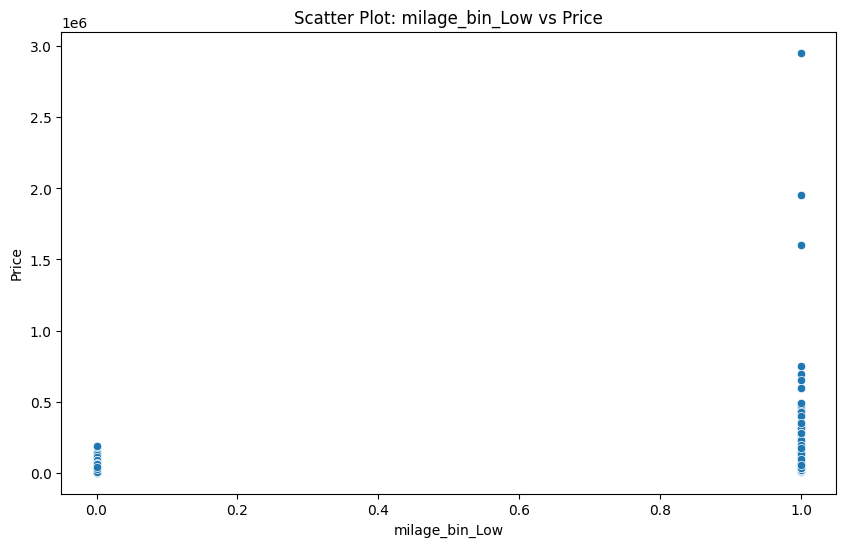

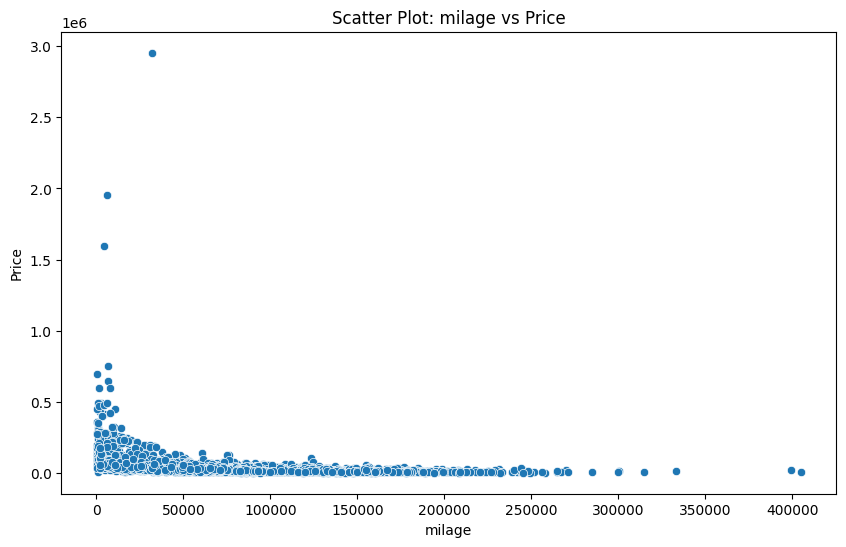

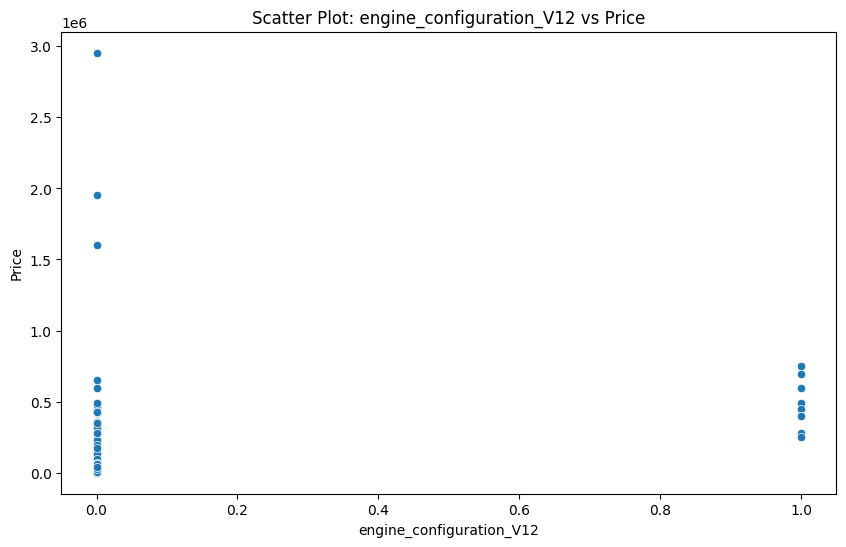

In [9]:
# Generate the correlation matrix
corr_matrix = data.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

print(corr_matrix['price'].abs().sort_values(ascending=False))

# Find the top 3 features that have the highest correlation with the target variable 'Price'
top_features = corr_matrix['price'].abs().sort_values(ascending=False).index[1:4]

print("Top 3 features highly correlated with 'Price' are:", top_features[0], top_features[1], top_features[2])
# Plot scatter plots for the top 3 features against 'Price'
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=feature, y='price')
    plt.title(f'Scatter Plot: {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

In [10]:
train = data.drop(columns=['price'])
train_target = data['price']
feature_names = train.columns.tolist()
scaler = StandardScaler()
train = scaler.fit_transform(train)
X_train, X_dev, y_train, y_dev = train_test_split(train, train_target, test_size=0.2, random_state=42)

# <font size="5">Hyperparameter Tuning with Grid Search</font>

In [11]:
# Function to perform grid search and return best model and its RMSE
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

In [12]:
# Define parameter grids for each model
lgb_param_grid = {
    'num_leaves': [20, 40, 60],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 150, 250],
    'reg_alpha': [0.0, 0.2, 0.4],
    'reg_lambda': [0.0, 0.2, 0.4]
}

xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'gamma': [0,0.2, 0.4],
    'subsample': [0.6, 0.8, 1.0]
}

et_param_grid = {
    'n_estimators': [100, 200, 350],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8],
    'max_depth': [None, 20, 30]
}

In [13]:
# Perform grid search for each model
lgb_grid_search = perform_grid_search(lgb.LGBMRegressor(verbose=-1), lgb_param_grid, X_train, y_train)
print("Best LightGBM Parameters: ", lgb_grid_search.best_params_)
print("Best LightGBM RMSE: ", np.sqrt(np.abs(lgb_grid_search.best_score_)))

xgb_grid_search = perform_grid_search(xgb.XGBRegressor(), xgb_param_grid, X_train, y_train)
print("Best XGBoost Parameters: ", xgb_grid_search.best_params_)
print("Best XGBoost RMSE: ", np.sqrt(np.abs(xgb_grid_search.best_score_)))

et_grid_search = perform_grid_search(ExtraTreesRegressor(), et_param_grid, X_train, y_train)
print("Best ExtraTrees Parameters: ", et_grid_search.best_params_)
print("Best ExtraTrees RMSE: ", np.sqrt(np.abs(et_grid_search.best_score_)))

Best LightGBM Parameters:  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
Best LightGBM RMSE:  67746.42237695858
Best XGBoost Parameters:  {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best XGBoost RMSE:  68489.67543255084
Best ExtraTrees Parameters:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ExtraTrees RMSE:  67251.74163216981


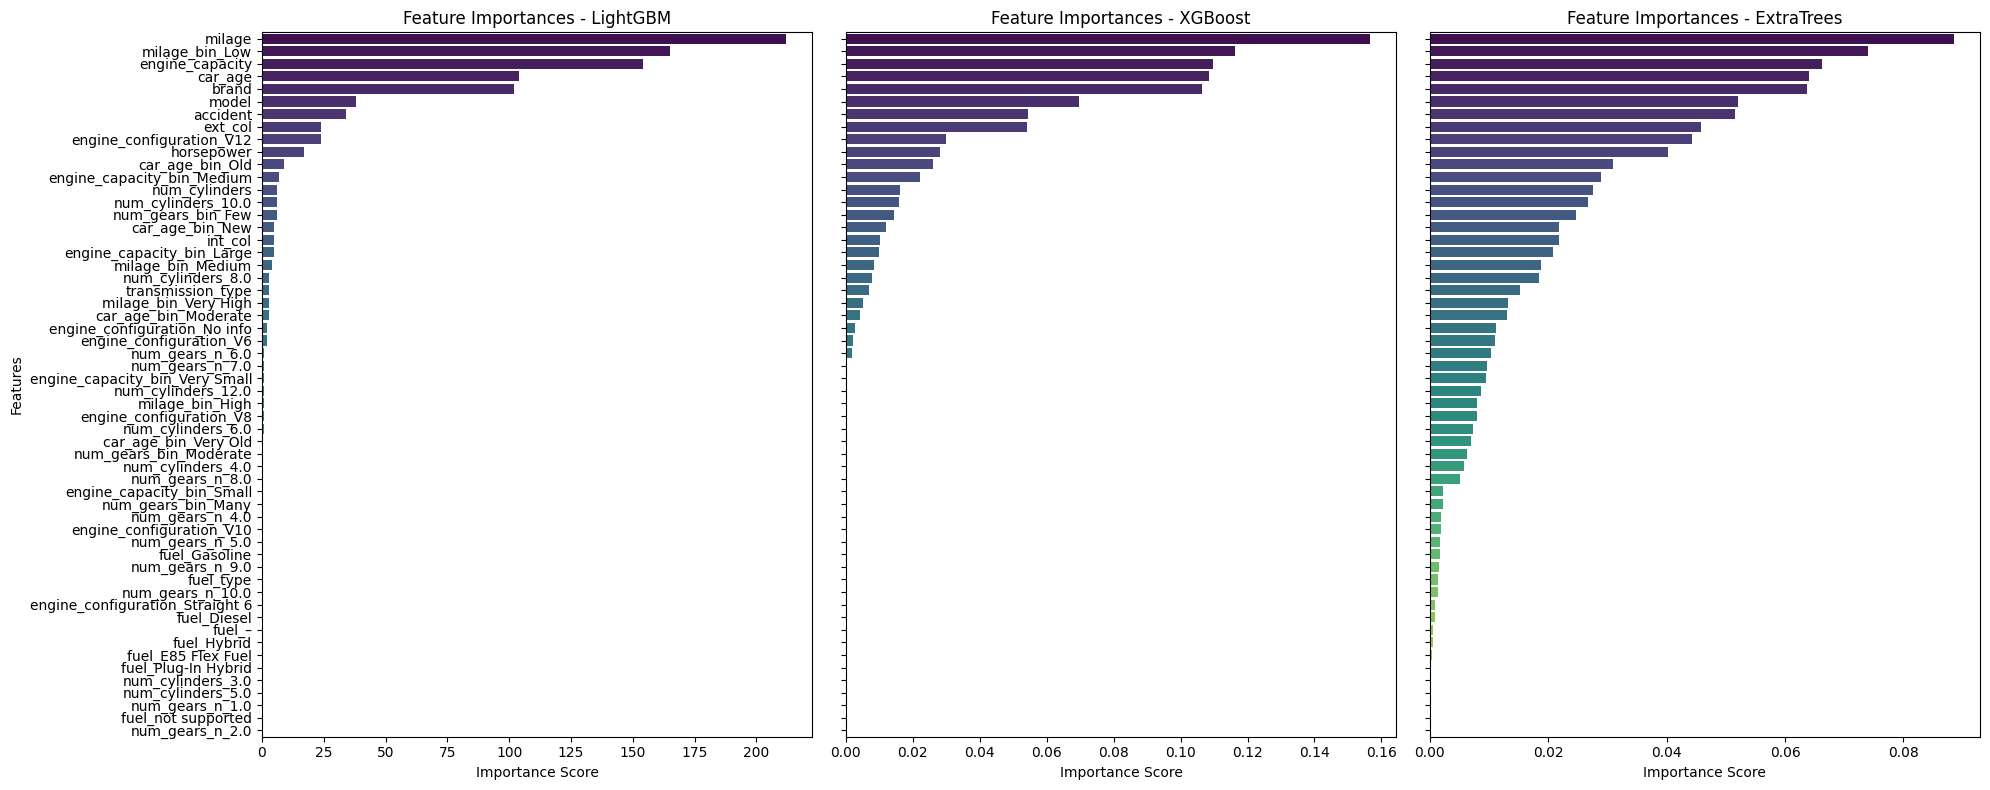

In [14]:
# Feature importance
lgb_best_model = lgb_grid_search.best_estimator_
xgb_best_model = xgb_grid_search.best_estimator_
et_best_model = et_grid_search.best_estimator_

lgb_importance = lgb_best_model.feature_importances_
xgb_importance = xgb_best_model.feature_importances_
et_importance = et_best_model.feature_importances_

# Create DataFrames to hold feature importances for each model
lgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_importance
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)

et_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn on subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# LightGBM plot
sns.barplot(ax=axes[0], x='Importance', y='Feature', data=lgb_feature_importance_df, palette='viridis')
axes[0].set_title('Feature Importances - LightGBM')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Features')

# XGBoost plot
sns.barplot(ax=axes[1], x='Importance', y='Feature', data=xgb_feature_importance_df, palette='viridis')
axes[1].set_title('Feature Importances - XGBoost')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('')

# ExtraTrees plot
sns.barplot(ax=axes[2], x='Importance', y='Feature', data=et_feature_importance_df, palette='viridis')
axes[2].set_title('Feature Importances - ExtraTrees')
axes[2].set_xlabel('Importance Score')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

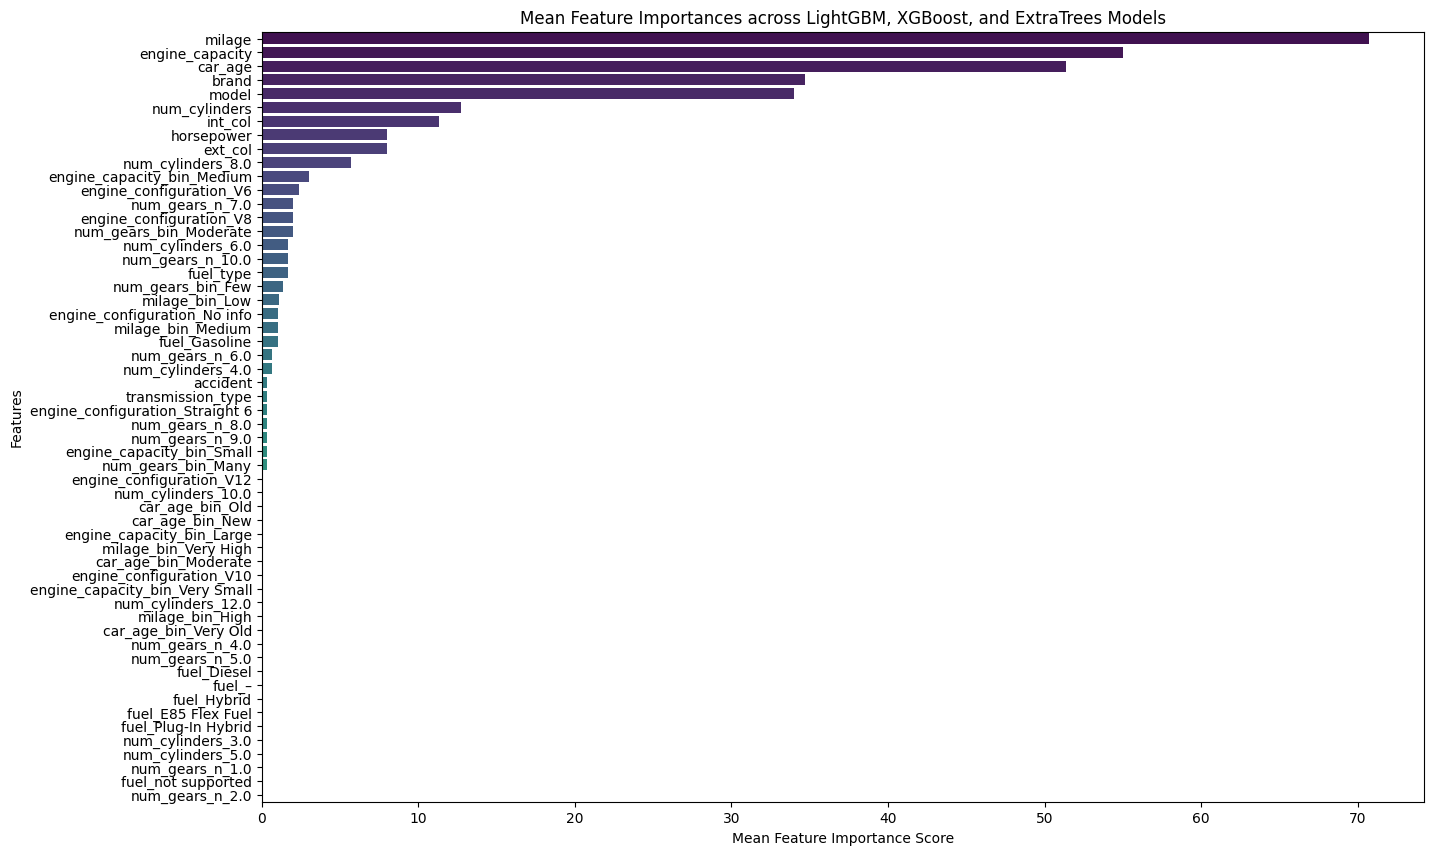

In [15]:
# Calculate mean importance across all models for each feature
mean_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Importance': np.mean([lgb_importance, xgb_importance, et_importance], axis=0)
})

# Sort mean_importance_df by Mean Importance in descending order
mean_importance_df = mean_importance_df.sort_values(by='Mean Importance', ascending=False)

# Plot the mean feature importances using seaborn
plt.figure(figsize=(15, 10))
sns.barplot(x='Mean Importance', y='Feature', data=mean_importance_df, palette='viridis')
plt.xlabel('Mean Feature Importance Score')
plt.ylabel('Features')
plt.title('Mean Feature Importances across LightGBM, XGBoost, and ExtraTrees Models')
plt.show()

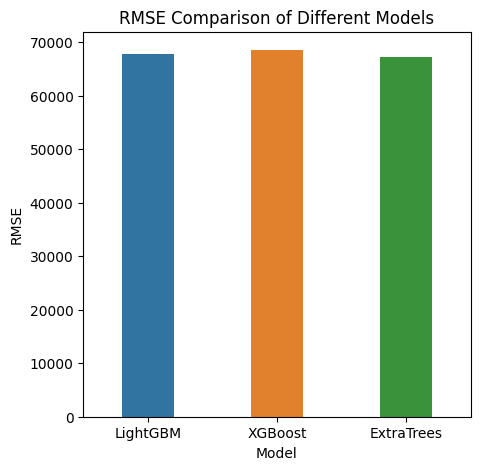

In [16]:
# Visualization of RMSE comparison
results = {
    'Model': ['LightGBM', 'XGBoost', 'ExtraTrees'],
    'RMSE': [np.sqrt(np.abs(lgb_grid_search.best_score_)), np.sqrt(np.abs(xgb_grid_search.best_score_)), np.sqrt(np.abs(et_grid_search.best_score_))]
}

results_df = pd.DataFrame(results)

plt.figure(figsize=(5, 5))
sns.barplot(x='Model', y='RMSE', data=results_df, width=0.4)
plt.title('RMSE Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()